In [110]:
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from matplotlib import colors

In [111]:
numRows = 5                 # SOM lentelės eilučių skaičius
numCols = 5                # SOM lentelės stulpelių skaičius
maxLearningRate = 0.2      # Pradinis mokymo parametras
epochs = 400               # Epochų skaičius
maxManhatanDistance = 4           # Pradinis Manheteno atstumas
fileName = 'iris.data'       # Duomenų failo pavadinimas
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] # Klasių pavadinimai

In [112]:
# Irisų duomenų aibėje, duomenų reikšmėms priskiriamas numeris, 
# duomenys sumaišomi, paskutinis stulpelis(klasės reikšmė) perkeliama į atskirą masyva) ir išmetama.
def prepareIrisData(inputFile: str) -> (np.ndarray, [int]):
    outputFile= inputFile.replace('.data', '2.csv')
    with open(inputFile, 'r') as fileInput:
        with open(outputFile, 'w') as file:
            for row in fileInput:
                modifiedString = row
                for i in range(len(labels)):
                    modifiedString = modifiedString.replace(labels[i], str(i))
                file.write(modifiedString)
    inputData = readDataFromFile(outputFile, 0)
    np.random.shuffle(inputData)
    output = inputData[:, -1]
    inputData = np.delete(inputData, -1, axis=1)
    return inputData, output

def readDataFromFile(filename: str, skipRows: int = 1) -> np.ndarray:
    return np.loadtxt(filename, delimiter=',',skiprows=skipRows)

def euclideanDistance(x: np.array, y: np.array) -> float:
    return np.sqrt(np.sum(np.power(x - y, 2)))

def manhattanDistance(x: np.array, y: np.array) -> float:
    return np.sum(np.abs(x - y))

def normalizeData(data: np.ndarray) -> np.ndarray:
    return (data - np.min(data, axis=0) - np.max(data,axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

#figure out this and how it works
# Neurono-nugalėtojo paieška
def winningNeuron(data, t, som, numRows, numCols):
  winner = [0,0]
  shortestDistance = np.sqrt(data.shape[1])  # Kintamasis pradžioje inicializuojamas didžiausiu įmanomu atstumu
  for row in range(numRows):
    for col in range(numCols):
      distance = euclideanDistance(som[row][col], data[t])
      if distance < shortestDistance:
        shortestDistance = distance
        winner = [row,col]
  return winner

# figure out this and how it works
# Didėjant epochos skaičiui apskaičiuojamas vis mažesnis mokymo parametras ir
# didžiausias leistinas Manheteno atstumas, kuriuo kaimynai nutolę nuo
# neurono-nugalėtojo
def decay(step, epochs,learningRate,maxManhatanDistance):
  coefficient = 1.0 - (np.float64(step)/epochs)
  learningRate = coefficient * learningRate
  neighbourhoodRange = ceil(coefficient * maxManhatanDistance)
  return learningRate, neighbourhoodRange

def SOMTraining(irisData, epochs:int, maxManhatanDistance:int, numRows: int, numCols: int):
  # Inicializuojama matrica su atsitikinėmis vektorių reikšmėmis
  numDimensions = irisData.shape[1]
  np.random.seed(40)
  som = np.random.random_sample(size=(numRows, numCols, numDimensions))

  for epoch in range(epochs):
    learningRate, neighbourhoodRange = decay(epoch, epochs, maxLearningRate, maxManhatanDistance)
    for t in range(irisData.shape[0]):
      winner = np.array(winningNeuron(irisData, t, som, numRows, numCols)) # Randamas neuronas-nugalėtojas duotam vektoriui

      # Atnaujinami neuronų svoriai
      # Naudojama burbuliuko kaimynystės funkcija, kur atnaujinami tik į
      # neurono-nugalėtojo kaimynus patenkančių vektorių svoriai
      for row in range(numRows):
        for col in range(numCols):
          if manhattanDistance(np.array([row,col]),winner) <= neighbourhoodRange:
            som[row][col] += learningRate * (irisData[t] - som[row][col])

  return som

def drawMap(map, numRows, numCols):
  # Kiekviename langelyje parenkama vaizduoti ta klasė, kuri pasikartoja
  # dažniausiai tame langelyje
  labelMap = np.zeros(shape=(numRows, numCols), dtype=np.int16)
  for row in range(numRows):
    for col in range(numCols):
      labelList = map[row][col]
      if len(labelList) == 0:
        label = 3
      else:
        label = max(labelList, key=labelList.count)
      labelMap[row][col] = label

  cmap = colors.ListedColormap(['tab:blue', 'tab:green', 'tab:red', 'w'])
  colorMap = plt.imshow(labelMap, cmap=cmap)
  dataLabels = labels.copy()
  dataLabels.insert(len(dataLabels),'No class')
  cbar = plt.colorbar(colorMap, ticks=range(4))
  cbar.ax.set_yticklabels(dataLabels)

  plt.show()

def getMapAndQuantization(irisData, irisOutput, som):
   # Apmokytas SOM priskiria kiekvieno įeities vektoriaus klasę žemėlapio vietai,
   # kurioje yra neuronas-nugalėtojas

  map = np.empty(shape=(numRows, numCols), dtype=object)
  quantizationError = 0

  for row in range(numRows):
    for col in range(numCols):
      map[row][col] = []

  for t in range(irisData.shape[0]):
    winner = winningNeuron(irisData, t, som, numRows, numCols)
    map[winner[0]][winner[1]].append(irisOutput[t])
    quantizationError += euclideanDistance(irisData[t], som[winner[0]][winner[1]])
  return map, quantizationError/irisData.shape[0]


In [113]:
irisData, irisOutput = prepareIrisData('iris.data')
irisData = normalizeData(irisData)
irisData = np.array(irisData)
irisOutput = np.array(irisOutput)
print (irisOutput)

[1. 1. 2. 2. 0. 1. 1. 0. 2. 1. 2. 0. 2. 2. 0. 0. 1. 0. 1. 0. 0. 0. 2. 2.
 1. 1. 1. 2. 2. 2. 1. 0. 1. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 0. 1. 2.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 2. 2. 0. 2. 1. 0. 1. 0. 2. 0. 0. 0.
 0. 2. 2. 1. 2. 0. 0. 1. 1. 1. 0. 1. 2. 2. 0. 2. 0. 1. 0. 1. 0. 0. 0. 2.
 1. 0. 1. 0. 1. 0. 1. 2. 0. 2. 2. 1. 1. 0. 1. 1. 0. 0. 2. 2. 0. 0. 2. 0.
 0. 2. 2. 1. 2. 0. 2. 1. 0. 1. 0. 2. 2. 1. 2. 1. 2. 0. 0. 1. 0. 2. 1. 1.
 2. 2. 1. 0. 0. 2.]


In [114]:
som = SOMTraining(irisData, epochs, maxManhatanDistance, numRows, numCols)

# Apskaičiuojama kvantavimo paklaida
map, quantizationError = getMapAndQuantization(irisData, irisOutput, som)
print("Quantization error: ", quantizationError)


Quantization error:  0.11629549987505053


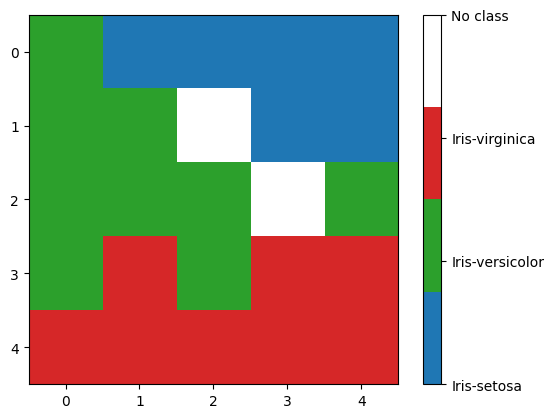

In [115]:
drawMap(map, numRows, numCols)